# 03 — Resampleo e Imputación Segura (por pozo)

**Objetivo:** 
1) Re-muestrear cada pozo a un eje de tiempo uniforme (p.ej., 10 min).  
2) Imputar **solo** huecos **cortos** y **dentro** de tramos operativos.  
3) **Nunca** imputar a través de **shutdowns** (CURRENT=0 y PRESS_DESC=0).  
4) Marcar `gap_flag`, `interp_flag`, `still_nan` y exportar auditoría por pozo.

**Entradas:** `../data/processed/df_filtrado.csv`  
**Salidas:** 
- `../data/processed/df_rs.csv` (dataset re-muestreado con flags)  
- `../data/processed/auditoria_resample_impute.csv` (resumen por pozo)  
- Figuras de validación en `../notebooks/data/figures/resample_impute/`


In [24]:
import os 
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Cargar configuración desde ../configs/default.yaml o ../conf/default.yaml --------
CFG_PATH = None
for cand in (Path("../configs/default.yaml"), Path("../conf/default.yaml")):
    if cand.exists():
        CFG_PATH = cand
        break

DEFAULT_CFG = {
    "RESAMPLE": "10min",
    "IMPUTE_LIMIT_STEPS": 3,  # 3*10min = 30 min
    "MAX_GAP_STEPS": 6,       # gap > 6 pasos (60 min) se considera largo -> no imputar
    # por defecto apuntamos al con_corriente:
    "INPUT_CSV": "../data/processed/df_filtrado_con_corriente.csv",
    "OUTPUT_CSV": "../data/processed/df_rs.csv",
    "AUDIT_CSV":  "../data/processed/auditoria_resample_impute.csv",
    "FIG_DIR": "../notebooks/data/figures/resample_impute",
    "READ_CSV_KWARGS": {
        "parse_dates": ["DATE"],
        "low_memory": False,
        "dtype": {"WellFailure": "string"}
    },
    # Defaults de listas (por si no están en YAML)
    "CORE_VARS": ["CURRENT","PRESS_DESC","TEMP_MOT"],
    "OPTIONAL_VARS": ["FREQUENCY","OUT_VOLT","TEMP_INT","VIBRATION"],
    "INTERP_VARS": ["CURRENT","PRESS_DESC","TEMP_INT","TEMP_MOT","VIBRATION"],
    "FFILL_VARS": ["FREQUENCY"],
    "EXCLUDE_WELLS": []
}

if CFG_PATH is not None:
    with CFG_PATH.open("r", encoding="utf-8") as f:
        CFG = yaml.safe_load(f)
    print("Usando configuración:", CFG_PATH.resolve())
else:
    CFG = DEFAULT_CFG
    print("⚠️ No se encontró default.yaml. Usando configuración por defecto en memoria.")

# -------- Parámetros principales --------
RESAMPLE      = CFG.get("RESAMPLE", DEFAULT_CFG["RESAMPLE"])
IMPUTE_LIMIT  = CFG.get("IMPUTE_LIMIT_STEPS", DEFAULT_CFG["IMPUTE_LIMIT_STEPS"])
MAX_GAP_STEPS = CFG.get("MAX_GAP_STEPS", DEFAULT_CFG["MAX_GAP_STEPS"])

INPUT_CSV = Path(CFG.get("INPUT_CSV", DEFAULT_CFG["INPUT_CSV"]))
OUTPUT_CSV= Path(CFG.get("OUTPUT_CSV", DEFAULT_CFG["OUTPUT_CSV"]))
AUDIT_CSV = Path(CFG.get("AUDIT_CSV",  DEFAULT_CFG["AUDIT_CSV"]))
FIG_DIR   = Path(CFG.get("FIG_DIR",    DEFAULT_CFG["FIG_DIR"]))
READ_KW   = CFG.get("READ_CSV_KWARGS", DEFAULT_CFG["READ_CSV_KWARGS"])

# -------- Listas de variables (desde YAML con fallback) --------
CORE_VARS     = CFG.get("CORE_VARS", DEFAULT_CFG["CORE_VARS"])
OPTIONAL_VARS = CFG.get("OPTIONAL_VARS", DEFAULT_CFG["OPTIONAL_VARS"])
INTERP_VARS   = CFG.get("INTERP_VARS", DEFAULT_CFG["INTERP_VARS"])
FFILL_VARS    = CFG.get("FFILL_VARS", DEFAULT_CFG["FFILL_VARS"])
EXCLUDE_WELLS = CFG.get("EXCLUDE_WELLS", DEFAULT_CFG["EXCLUDE_WELLS"])

# NUMERIC_VARS: unión CORE + OPCIONALES (evita duplicados y respeta orden)
NUMERIC_VARS = list(dict.fromkeys(list(CORE_VARS) + list(OPTIONAL_VARS)))

# -------- Crear carpeta de figuras --------
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"RESAMPLE={RESAMPLE} | IMPUTE_LIMIT={IMPUTE_LIMIT} | MAX_GAP_STEPS={MAX_GAP_STEPS}")
print("INPUT_CSV:", INPUT_CSV)
print("CORE_VARS:", CORE_VARS)
print("OPTIONAL_VARS:", OPTIONAL_VARS)
print("INTERP_VARS:", INTERP_VARS)
print("FFILL_VARS:", FFILL_VARS)
print("EXCLUDE_WELLS:", EXCLUDE_WELLS)



Usando configuración: C:\Users\Vìctor\OneDrive\Desktop\ESP Failure Prediction System\configs\default.yaml
RESAMPLE=10min | IMPUTE_LIMIT=3 | MAX_GAP_STEPS=6
INPUT_CSV: ..\data\processed\df_filtrado_con_corriente.csv
CORE_VARS: ['CURRENT', 'PRESS_DESC', 'TEMP_MOT']
OPTIONAL_VARS: ['FREQUENCY', 'OUT_VOLT', 'TEMP_INT', 'VIBRATION']
INTERP_VARS: ['CURRENT', 'PRESS_DESC', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION']
FFILL_VARS: ['FREQUENCY']
EXCLUDE_WELLS: ['DEEPWATER-L4I1KA']


Cargar datos y sanity check

In [25]:
# Cargar CSV de entrada
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"No existe el archivo de entrada: {INPUT_CSV}")

df = pd.read_csv(INPUT_CSV, **READ_KW)
# Excluir pozos definidos en YAML (ej.: DEEPWATER-L4I1KA)
if EXCLUDE_WELLS:
    df = df[~df["WELL_ID"].isin(EXCLUDE_WELLS)].copy()


df = df.sort_values(["WELL_ID","DATE"]).reset_index(drop=True)

# Crear columnas faltantes si alguna NUMERIC_VARS no existe (seguridad)
for col in NUMERIC_VARS:
    if col not in df.columns:
        df[col] = np.nan

# Info rápida
print("Shape:", df.shape)
print("Pozos únicos:", df["WELL_ID"].nunique())
print("Rango de fechas:", df["DATE"].min(), "→", df["DATE"].max())
display(df[["WELL_ID","DATE"] + CORE_VARS].head(5))



Shape: (114123, 15)
Pozos únicos: 49
Rango de fechas: 2020-01-01 00:00:00 → 2020-01-31 23:58:33


,WELL_ID,DATE,CURRENT,PRESS_DESC,TEMP_MOT
0,DEEPWATER-0KPXEZ,2020-01-01 08:34:54,20.600000,4009.4998,298.80002
1,DEEPWATER-0KPXEZ,2020-01-01 08:54:54,20.700001,4009.2998,298.80002
2,DEEPWATER-0KPXEZ,2020-01-01 09:14:54,20.700001,4008.0999,298.60001
3,DEEPWATER-0KPXEZ,2020-01-01 09:34:54,20.700001,4003.7000,298.60001
4,DEEPWATER-0KPXEZ,2020-01-01 09:54:54,20.799999,3998.7000,298.80002


Funciones utilitarias (resample + imputación segura)

In [26]:
def detect_shutdown_flags(frame: pd.DataFrame) -> pd.Series:
    """
    Shutdown ESTRICTO:
    - CURRENT y PRESS_DESC deben estar PRESENTES y ser EXACTAMENTE cero.
    - (Opcional) puedes reforzar con FREQUENCY==0 si está presente.
    """
    has_curr  = frame["CURRENT"].notna()
    has_pdesc = frame["PRESS_DESC"].notna()
    cond = has_curr & has_pdesc & (frame["CURRENT"]==0) & (frame["PRESS_DESC"]==0)

    # Si quisieras exigir FREQUENCY==0 cuando esté disponible:
    # has_freq = frame["FREQUENCY"].notna()
    # cond3 = has_curr & has_pdesc & has_freq & (frame["CURRENT"]==0) & (frame["PRESS_DESC"]==0) & (frame["FREQUENCY"]==0)
    # cond = cond3 | cond  # acepta ambos criterios (3-sensores o 2-sensores)

    return cond.astype(int)

def compute_gap_lengths(mask_nan: pd.Series) -> pd.Series:
    """
    Devuelve, para cada índice, la LONGITUD del bloque consecutivo de True (NaN)
    en el que cae ese índice. Si mask es False, devuelve 0.
    Ejemplo: [F,T,T,F,T] -> [0,2,2,0,1]
    """
    grp = (mask_nan != mask_nan.shift(fill_value=False)).cumsum()
    run_sizes = mask_nan.groupby(grp).transform('sum')
    return run_sizes.where(mask_nan, 0).astype(int)

def process_one_well(gpo: pd.DataFrame) -> pd.DataFrame:
    """
    Resamplea e imputa un pozo:
    - Resample 'RESAMPLE' con .mean() en NUMERIC_VARS.
    - Marca shutdown_flag (NO confundir NaN con cero).
    - Interpola SOLO en operativa, con limit=IMPUTE_LIMIT en INTERP_VARS y solo en gaps cortos (<=MAX_GAP_STEPS).
    - Forward-fill LIMITADO para FFILL_VARS (SOLO operativa y gaps cortos).
    - Flags sobre CORE_VARS: gap_flag_core, still_nan_core, interp_flag_core.
    - Flags por sensor: isnan_* (para auditoría).
    """
    gpo = gpo.sort_values("DATE").set_index("DATE")
    r = gpo[NUMERIC_VARS].resample(RESAMPLE).mean()
    r["WELL_ID"] = gpo["WELL_ID"].iloc[0]

    # Shutdown robusto
    r["shutdown_flag"] = detect_shutdown_flags(r)

    # Flags pre-imputación (solo CORE)
    r["gap_flag_core"] = r[CORE_VARS].isna().any(axis=1).astype(int)

    # Imputación solo en operativo
    oper_mask = r["shutdown_flag"] == 0

    # Interpolación temporal para continuas
    for col in INTERP_VARS:
        s = r[col].copy()
        nan_mask = s.isna() & oper_mask
        # tamaño del gap en pasos
        run_lengths = compute_gap_lengths(nan_mask)
        short_gap_mask = (run_lengths <= MAX_GAP_STEPS)

        s_interp = s.copy()
        s_interp.loc[oper_mask] = s_interp.loc[oper_mask].interpolate(
            method="time", limit=IMPUTE_LIMIT, limit_direction="forward"
        )
        # restaurar NaN donde el gap era largo
        s_interp.loc[oper_mask & (~short_gap_mask)] = np.nan
        r[col] = s_interp

    # Forward-fill limitado para set-points
    for col in FFILL_VARS:
        s = r[col].copy()
        nan_mask = s.isna() & oper_mask
        run_lengths = compute_gap_lengths(nan_mask)
        short_gap_mask = (run_lengths <= MAX_GAP_STEPS)

        s_ff = s.copy()
        s_ff.loc[oper_mask] = s_ff.loc[oper_mask].ffill(limit=IMPUTE_LIMIT)  # sin backfill
        s_ff.loc[oper_mask & (~short_gap_mask)] = np.nan
        r[col] = s_ff

    # Flags post-imputación (solo CORE)
    r["still_nan_core"]   = r[CORE_VARS].isna().any(axis=1).astype(int)
    r["interp_flag_core"] = ((r["gap_flag_core"] == 1) & (r["still_nan_core"] == 0)).astype(int)

    # Flags por sensor para auditoría
    for col in NUMERIC_VARS:
        r[f"isnan_{col}"] = r[col].isna().astype(int)

    # Orden columnas
    r = r.reset_index()
    cols_order = (["DATE"] + NUMERIC_VARS + ["WELL_ID","shutdown_flag","gap_flag_core","still_nan_core","interp_flag_core"]
                  + [c for c in r.columns if c.startswith("isnan_")])
    r = r[cols_order]
    return r


Ejecutar por pozo y guardar resultados

In [27]:
df_rs_list = []
for well, g in df.groupby("WELL_ID", sort=False):
    df_rs_list.append(process_one_well(g))

df_rs = pd.concat(df_rs_list, ignore_index=True)
df_rs = df_rs.sort_values(["WELL_ID","DATE"]).reset_index(drop=True)

# Guardar
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df_rs.to_csv(OUTPUT_CSV, index=False)

print("✅ df_rs guardado en:", OUTPUT_CSV)
print("Shape:", df_rs.shape, "| Pozos:", df_rs["WELL_ID"].nunique())
display(df_rs.head(8))


✅ df_rs guardado en: ..\data\processed\df_rs.csv
Shape: (190808, 20) | Pozos: 49


,DATE,CURRENT,PRESS_DESC,TEMP_MOT,FREQUENCY,OUT_VOLT,TEMP_INT,VIBRATION,WELL_ID,shutdown_flag,gap_flag_core,still_nan_core,interp_flag_core,isnan_CURRENT,isnan_PRESS_DESC,isnan_TEMP_MOT,isnan_FREQUENCY,isnan_OUT_VOLT,isnan_TEMP_INT,isnan_VIBRATION
0,2020-01-01 08:30:00,20.600000,4009.49980,298.800020,58.0,NaN,268.0,0.200136,DEEPWATER-0KPXEZ,0,0,0,0,0,0,0,0,1,0,0
1,2020-01-01 08:40:00,20.650001,4009.39980,298.800020,58.0,NaN,268.0,0.200136,DEEPWATER-0KPXEZ,0,1,0,1,0,0,0,0,1,0,0
2,2020-01-01 08:50:00,20.700001,4009.29980,298.800020,58.0,NaN,268.0,0.200136,DEEPWATER-0KPXEZ,0,0,0,0,0,0,0,0,1,0,0
3,2020-01-01 09:00:00,20.700001,4008.69985,298.700015,58.0,NaN,268.0,0.250170,DEEPWATER-0KPXEZ,0,1,0,1,0,0,0,0,1,0,0
4,2020-01-01 09:10:00,20.700001,4008.09990,298.600010,58.0,NaN,268.0,0.300204,DEEPWATER-0KPXEZ,0,0,0,0,0,0,0,0,1,0,0
5,2020-01-01 09:20:00,20.700001,4005.89995,298.600010,58.0,NaN,268.0,0.250170,DEEPWATER-0KPXEZ,0,1,0,1,0,0,0,0,1,0,0
6,2020-01-01 09:30:00,20.700001,4003.70000,298.600010,58.0,NaN,268.0,0.200136,DEEPWATER-0KPXEZ,0,0,0,0,0,0,0,0,1,0,0
7,2020-01-01 09:40:00,20.750000,4001.20000,298.700015,58.0,NaN,268.0,0.200136,DEEPWATER-0KPXEZ,0,1,0,1,0,0,0,0,1,0,0


Auditoría por pozo + guardar

In [28]:
def audit_by_well(df_rs: pd.DataFrame) -> pd.DataFrame:
    agg = (
        df_rs.groupby("WELL_ID")
             .agg(
                 registros=("DATE","size"),
                 pct_shutdown=("shutdown_flag", lambda x: 100*x.mean()),
                 pct_gap_core=("gap_flag_core", lambda x: 100*x.mean()),
                 pct_interp_core=("interp_flag_core", lambda x: 100*x.mean()),
                 pct_still_nan_core=("still_nan_core", lambda x: 100*x.mean()),
             )
             .reset_index()
    )
    # Disponibilidad por sensor
    for col in NUMERIC_VARS:
        agg[f"disp_{col}"] = (
            100 * df_rs.groupby("WELL_ID")[col].apply(lambda s: s.notna().mean())
        ).values
    return agg

audit = audit_by_well(df_rs).sort_values("registros", ascending=False)

# Guardar auditoría
AUDIT_CSV.parent.mkdir(parents=True, exist_ok=True)
audit.to_csv(AUDIT_CSV, index=False)

print("✅ Auditoría guardada en:", AUDIT_CSV)
display(audit.head(12))

# Resumen general
resumen = {
    "Pozos": df_rs["WELL_ID"].nunique(),
    "Registros": len(df_rs),
    "% filas en shutdown": round(100*df_rs["shutdown_flag"].mean(), 2),
    "% filas con gap CORE (pre)": round(100*df_rs["gap_flag_core"].mean(), 2),
    "% filas imputadas CORE (efectivo)": round(100*df_rs["interp_flag_core"].mean(), 2),
    "% filas aún NaN CORE (gaps largos)": round(100*df_rs["still_nan_core"].mean(), 2),
}
print(resumen)


✅ Auditoría guardada en: ..\data\processed\auditoria_resample_impute.csv


,WELL_ID,registros,pct_shutdown,pct_gap_core,pct_interp_core,pct_still_nan_core,disp_CURRENT,disp_PRESS_DESC,disp_TEMP_MOT,disp_FREQUENCY,disp_OUT_VOLT,disp_TEMP_INT,disp_VIBRATION
16,DEEPWATER-DTL53P,4416,0.00000,9.601449,9.601449,0.000000,100.000000,100.000000,100.000000,100.000000,93.115942,100.000000,100.000000
11,DEEPWATER-BPUSBG,4415,0.00000,53.748584,52.751982,0.996602,99.637599,99.003398,99.003398,99.682899,50.939977,99.003398,99.003398
2,DEEPWATER-1AD32W,4415,0.02265,51.483579,46.115515,5.368063,94.767837,94.631937,94.631937,94.767837,0.000000,94.609287,94.609287
7,DEEPWATER-4TYG1P,4415,0.00000,55.922990,55.107588,0.815402,99.592299,99.229898,99.229898,99.592299,46.251416,99.116648,99.229898
4,DEEPWATER-1WHBG2,4415,0.00000,52.140430,51.143828,0.996602,99.479049,99.003398,99.048698,99.388448,0.000000,99.048698,99.026048
9,DEEPWATER-AHJLPP,4415,0.02265,53.907135,52.253681,1.653454,98.527746,98.369196,98.437146,98.505096,0.000000,98.459796,98.369196
13,DEEPWATER-BZZIEL,4415,0.00000,47.519819,44.711212,2.808607,98.142695,97.259343,97.191393,98.391846,55.492639,97.214043,97.191393
6,DEEPWATER-453GJ0,4415,0.11325,56.602492,48.312571,8.289921,93.612684,91.710079,91.710079,93.612684,44.439411,91.710079,91.710079
41,DEEPWATER-TXV4MX,4415,0.09060,54.926387,54.201586,0.724802,99.524349,99.275198,99.275198,99.524349,0.000000,99.275198,99.275198
35,DEEPWATER-MU3BOW,4415,0.00000,59.569649,58.097395,1.472254,99.252548,98.527746,98.618347,91.710079,0.000000,98.618347,98.573046


{'Pozos': 49, 'Registros': 190808, '% filas en shutdown': np.float64(1.52), '% filas con gap CORE (pre)': np.float64(52.46), '% filas imputadas CORE (efectivo)': np.float64(46.17), '% filas aún NaN CORE (gaps largos)': np.float64(6.3)}


Figuras “antes/después” (pozos ejemplo)

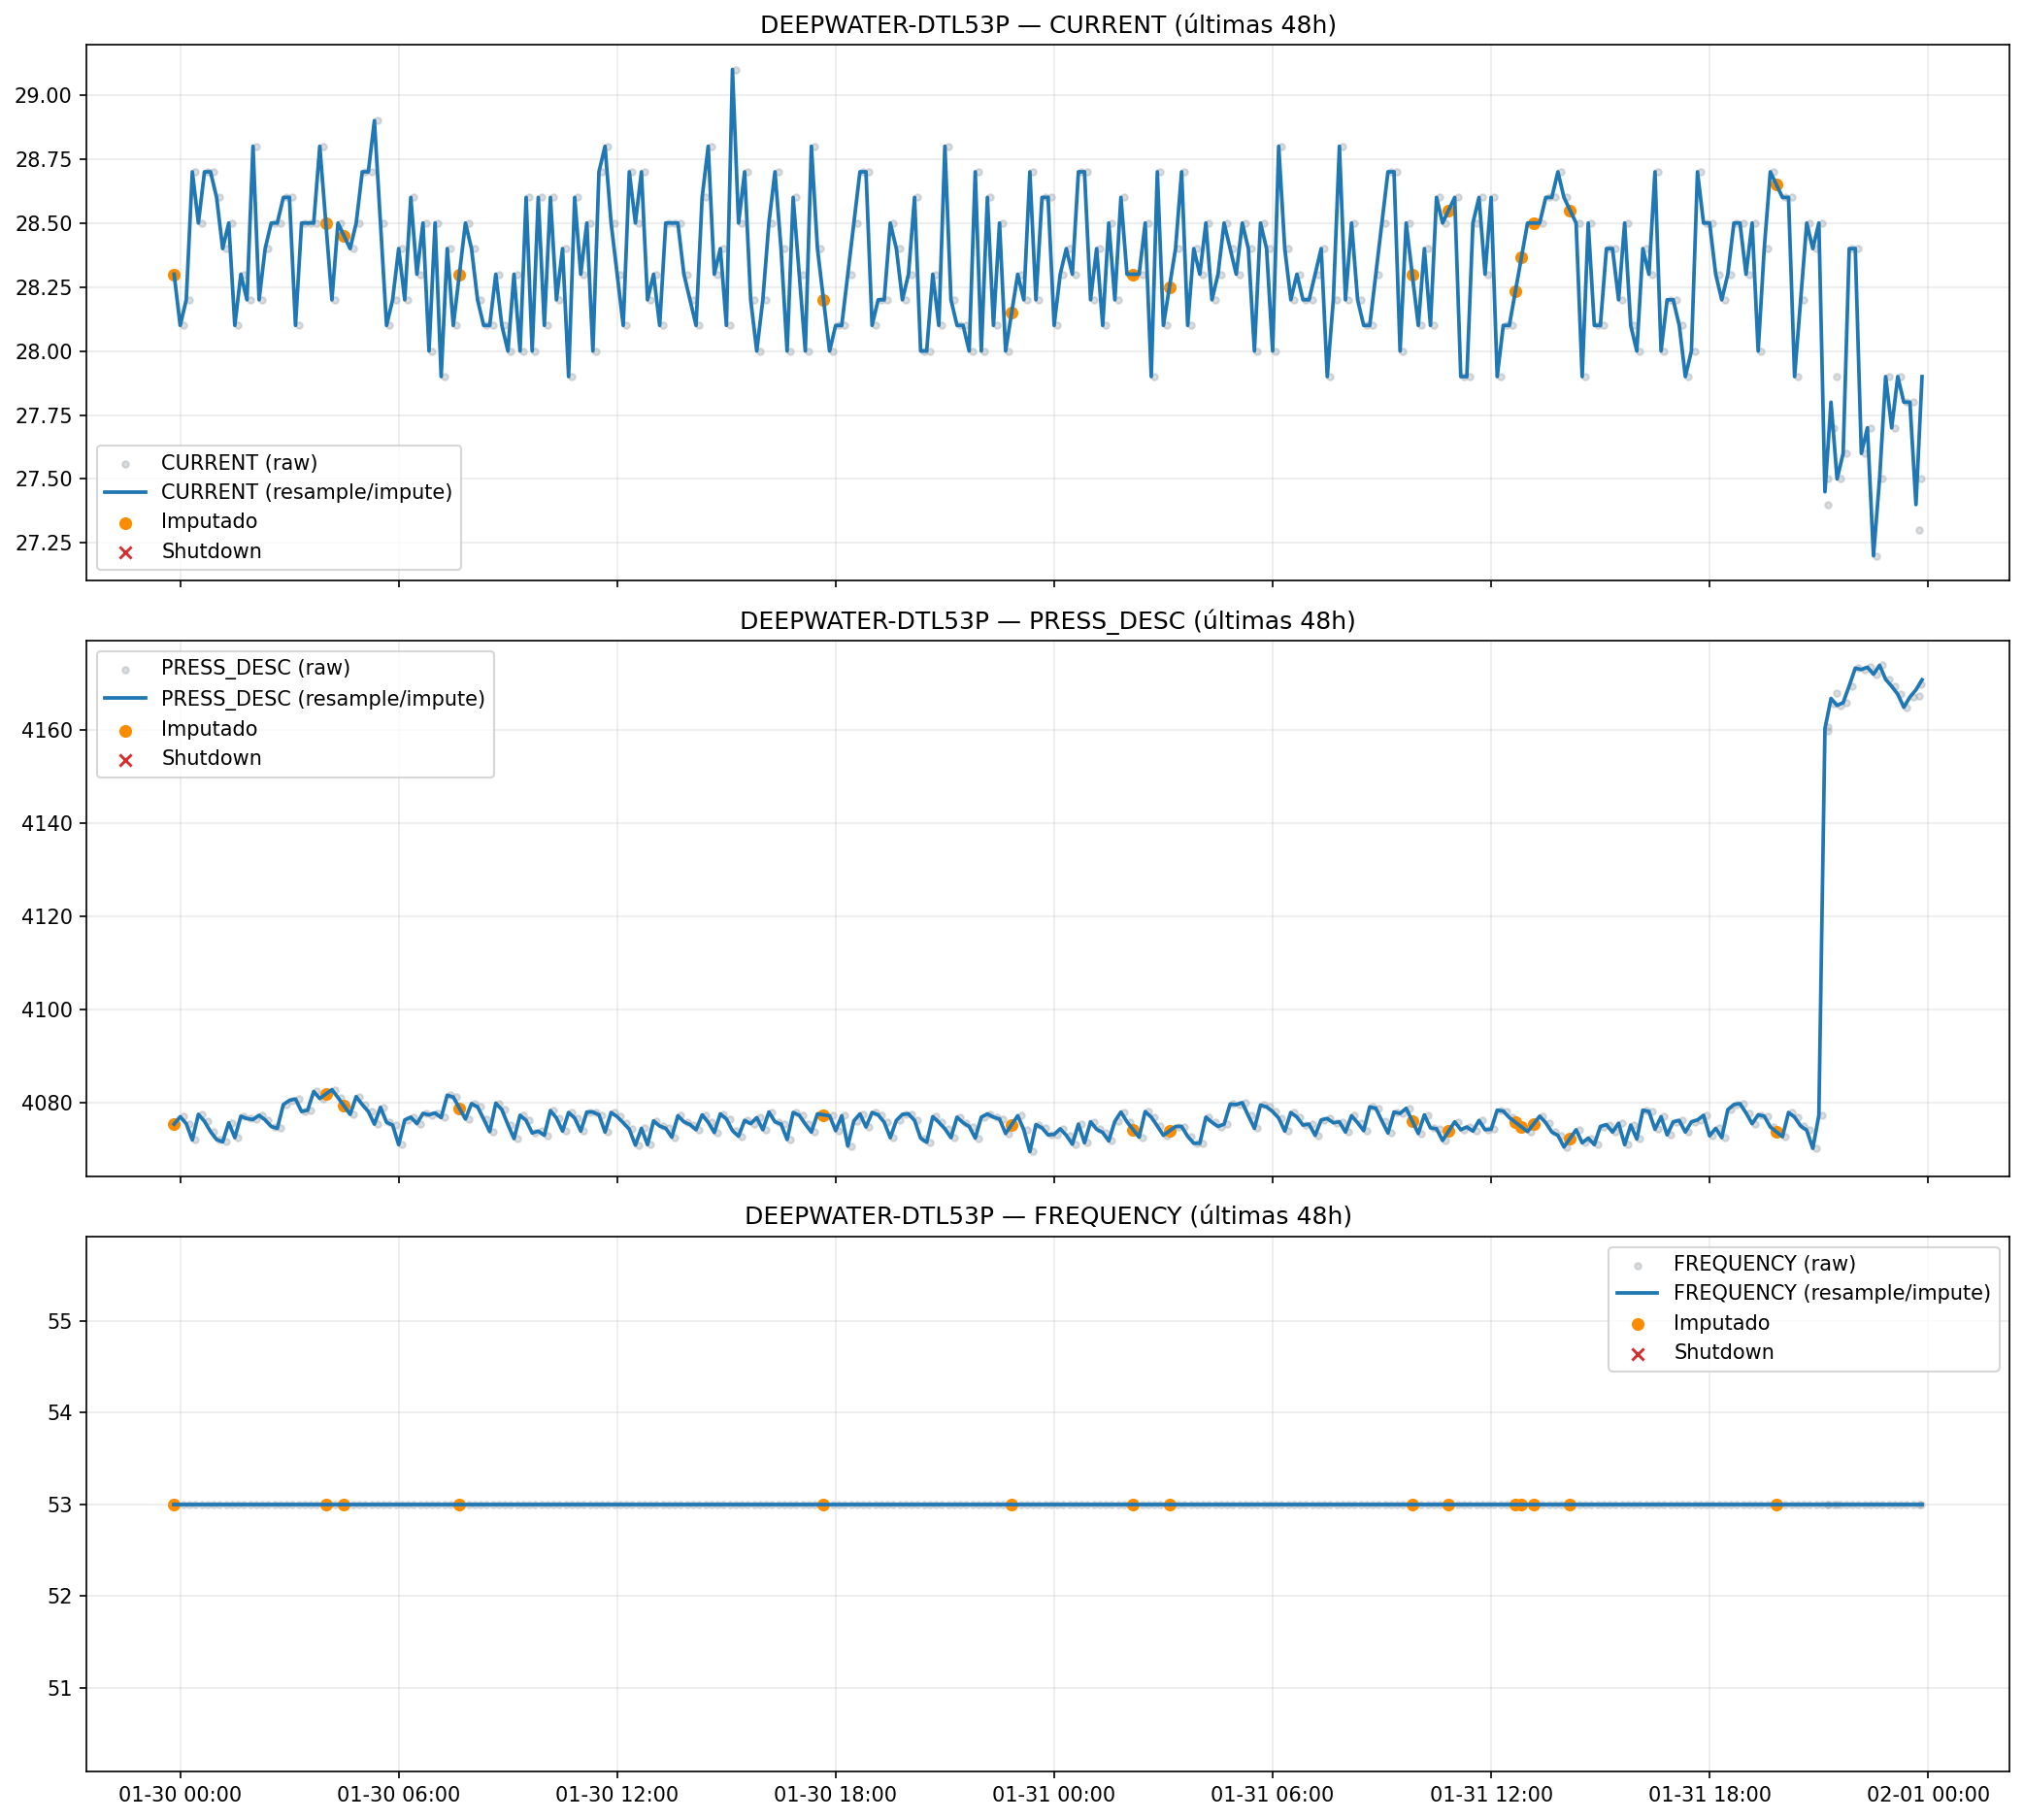

Figuras guardadas: DEEPWATER-DTL53P_before_after.png, DEEPWATER-DTL53P_before_after.svg


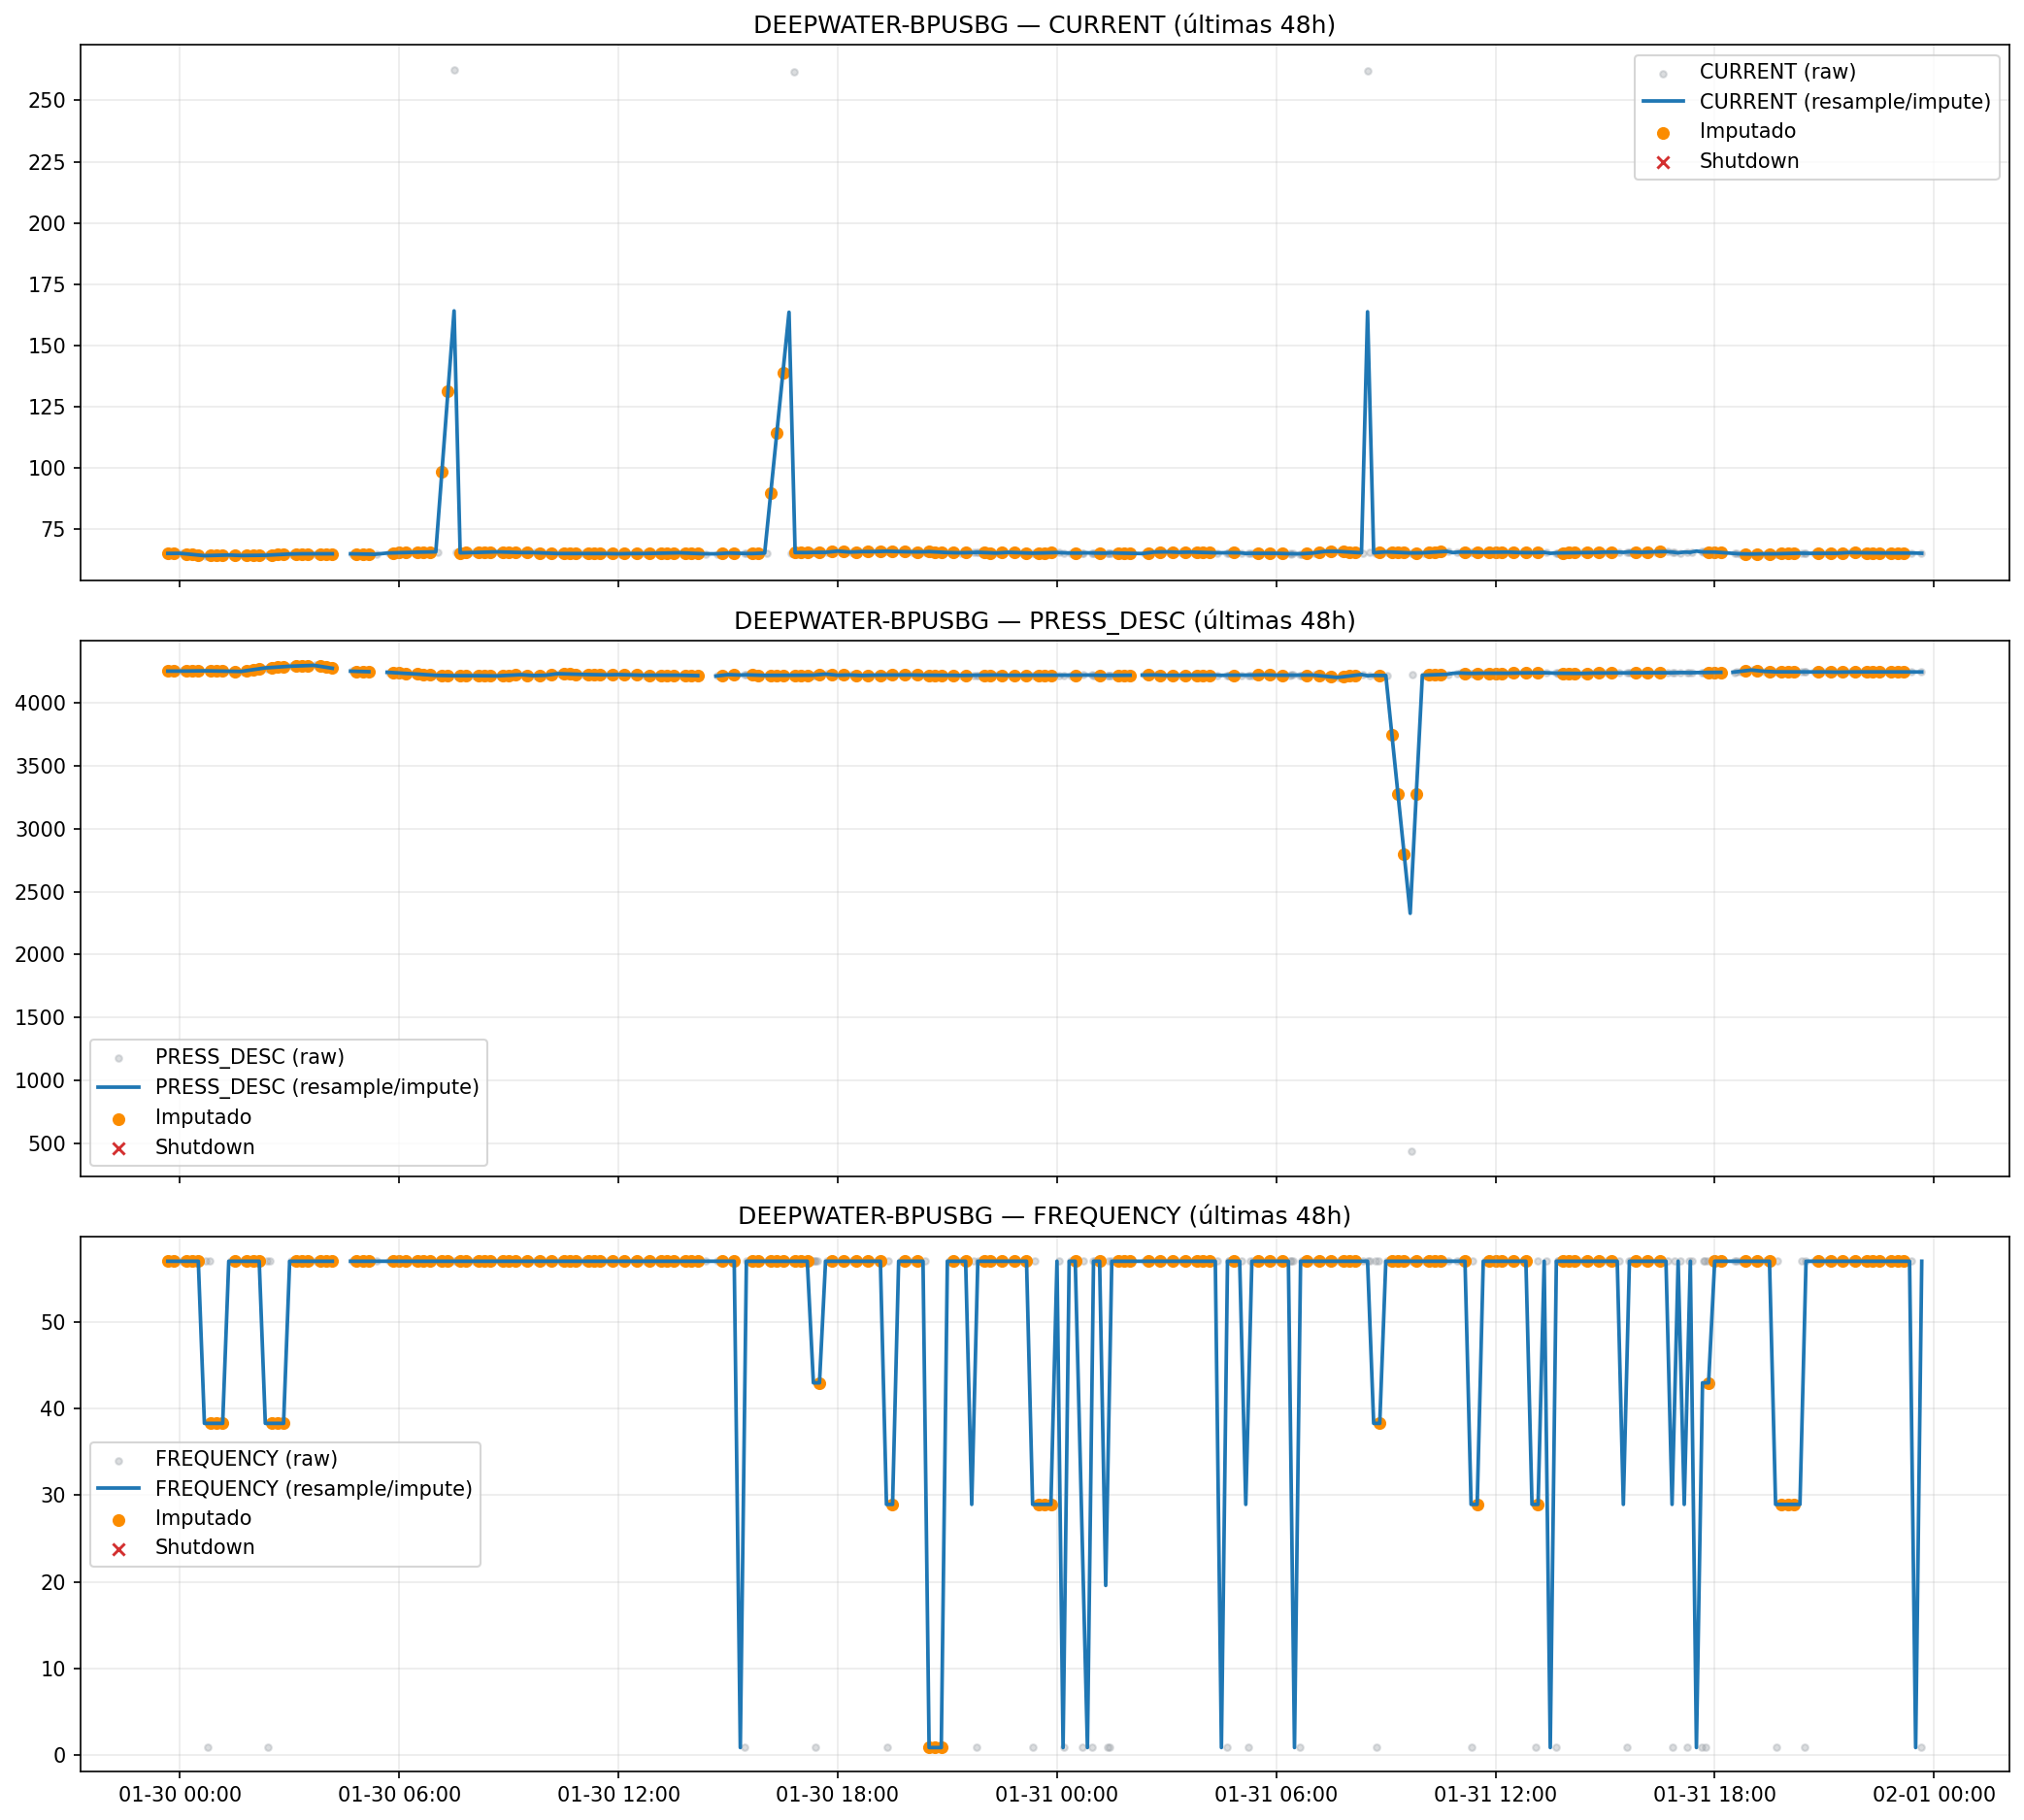

Figuras guardadas: DEEPWATER-BPUSBG_before_after.png, DEEPWATER-BPUSBG_before_after.svg


In [34]:
# ========= Gráficas =========
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# Config visual suave (similar al original)
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

def plot_and_save_well(df_raw, df_proc, well_id, vars_plot=("CURRENT","PRESS_DESC","FREQUENCY"),
                       hours=48, fig_dir=FIG_DIR, dpi=300):
    """Genera la figura del pozo (raw vs resample/impute) y la guarda (PNG+SVG)."""
    a = df_raw[df_raw["WELL_ID"]==well_id].copy()
    b = df_proc[df_proc["WELL_ID"]==well_id].copy()
    if a.empty or b.empty:
        print(f"[{well_id}] sin datos para graficar."); 
        return

    end = b["DATE"].max()
    start = end - pd.Timedelta(hours=hours)
    a = a[(a["DATE"]>=start) & (a["DATE"]<=end)]
    b = b[(b["DATE"]>=start) & (b["DATE"]<=end)]

    # Máscaras fila
    m_sd  = (b["shutdown_flag"]==1)
    m_imp = (b["interp_flag_core"]==1)

    nrows = len(vars_plot)
    fig, axes = plt.subplots(nrows, 1, figsize=(14, 4.2*nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    for ax, col in zip(axes, vars_plot):
        if col not in b.columns:
            ax.set_visible(False)
            continue

        t, y = b["DATE"], b[col]

        # 1) Raw (gris claro, puntos pequeños)
        if col in a.columns:
            ax.scatter(a["DATE"], a[col], s=10, alpha=0.35, color="#9AA0A6", label=f"{col} (raw)")

        # 2) Serie procesada (azul, línea principal)
        ax.plot(t, y, linewidth=1.8, label=f"{col} (resample/impute)")

        # 3) Puntos imputados (naranja, sobre la serie)
        m_imp_col = m_imp & y.notna()
        ax.scatter(t[m_imp_col], y[m_imp_col], s=28, color="#FB8C00", label="Imputado")

        # 4) Shutdowns (✖ rojo, sobre la serie)
        m_sd_col = m_sd & y.notna()
        ax.scatter(t[m_sd_col], y[m_sd_col], s=34, marker="x", color="#D32F2F", linewidths=1.4, label="Shutdown")

        # Títulos y ejes
        ax.set_title(f"{well_id} — {col} (últimas {hours}h)")
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))

        # Leyenda sin duplicados
        h, l = ax.get_legend_handles_labels()
        seen, H, L = set(), [], []
        for hh, ll in zip(h, l):
            if ll not in seen:
                H.append(hh); L.append(ll); seen.add(ll)
        ax.legend(H, L, loc="best", frameon=True)

    fig.tight_layout()

    # Guardar (PNG alta calidad + SVG vector)
    fig_dir = Path(fig_dir); fig_dir.mkdir(parents=True, exist_ok=True)
    out_png = fig_dir / f"{well_id}_before_after.png"
    out_svg = fig_dir / f"{well_id}_before_after.svg"
    plt.savefig(out_png, dpi=dpi)
    plt.savefig(out_svg)
    plt.show()
    print(f"Figuras guardadas: {out_png.name}, {out_svg.name}")

# ======= Ejecutar para una lista de pozos =======
# Usa los 2 con más registros, o define manualmente:
wells_to_plot = df_rs["WELL_ID"].value_counts().index[:2].tolist()
# Ejemplo manual:
# wells_to_plot = ["DEEPWATER-DTL53P", "DEEPWATER-1AD32W"]

for w in wells_to_plot:
    plot_and_save_well(df_raw=df, df_proc=df_rs, well_id=w,
                       vars_plot=("CURRENT","PRESS_DESC","FREQUENCY"), hours=48, dpi=300)




Pozos “críticos” por gaps largos o baja disponibilidad

In [30]:
# Top pozos por % de gaps CORE que NO se pudieron imputar (gaps largos / sensores clave ausentes)
crit_long = audit.sort_values("pct_still_nan_core", ascending=False).head(10)
print("🔴 Top 10 pozos por % de gaps CORE largos (no imputados):")
display(crit_long[["WELL_ID","pct_still_nan_core","pct_gap_core","pct_interp_core","pct_shutdown","registros"]])

# Top pozos por baja disponibilidad de OUT_VOLT (si lo usas como opcional)
if "disp_OUT_VOLT" in audit.columns:
    crit_outv = audit.sort_values("disp_OUT_VOLT", ascending=True).head(10)
    print("🟠 Top 10 pozos por baja disponibilidad OUT_VOLT:")
    display(crit_outv[["WELL_ID","disp_OUT_VOLT","registros"]])


🔴 Top 10 pozos por % de gaps CORE largos (no imputados):


,WELL_ID,pct_still_nan_core,pct_gap_core,pct_interp_core,pct_shutdown,registros
32,DEEPWATER-LQB3RR,49.104917,49.104917,0.000000,50.895083,4413
23,DEEPWATER-GMAJKI,47.907558,56.464710,8.557152,36.477202,1601
24,DEEPWATER-GP0VTX,46.159075,68.434172,22.275096,0.362565,4413
21,DEEPWATER-FS1PMT,40.022650,72.706682,32.684032,0.000000,4415
42,DEEPWATER-U3TTRI,26.343233,67.807753,41.464521,0.022671,4411
39,DEEPWATER-TPS1RK,23.997281,58.984818,34.987537,0.000000,4413
15,DEEPWATER-DOA2ZP,11.366006,60.688217,49.322211,0.104275,959
17,DEEPWATER-EEJC2O,8.427730,54.372451,45.944721,0.000000,4414
6,DEEPWATER-453GJ0,8.289921,56.602492,48.312571,0.113250,4415
25,DEEPWATER-GROQ2A,8.065247,54.916176,46.850929,0.000000,4414


🟠 Top 10 pozos por baja disponibilidad OUT_VOLT:


,WELL_ID,disp_OUT_VOLT,registros
2,DEEPWATER-1AD32W,0.0,4415
4,DEEPWATER-1WHBG2,0.0,4415
9,DEEPWATER-AHJLPP,0.0,4415
41,DEEPWATER-TXV4MX,0.0,4415
19,DEEPWATER-EQEM2A,0.0,4415
21,DEEPWATER-FS1PMT,0.0,4415
35,DEEPWATER-MU3BOW,0.0,4415
8,DEEPWATER-A5W4QG,0.0,4413
0,DEEPWATER-0KPXEZ,0.0,4413
32,DEEPWATER-LQB3RR,0.0,4413


Pozo elegido para vista centrada en shutdown: DEEPWATER-LQB3RR


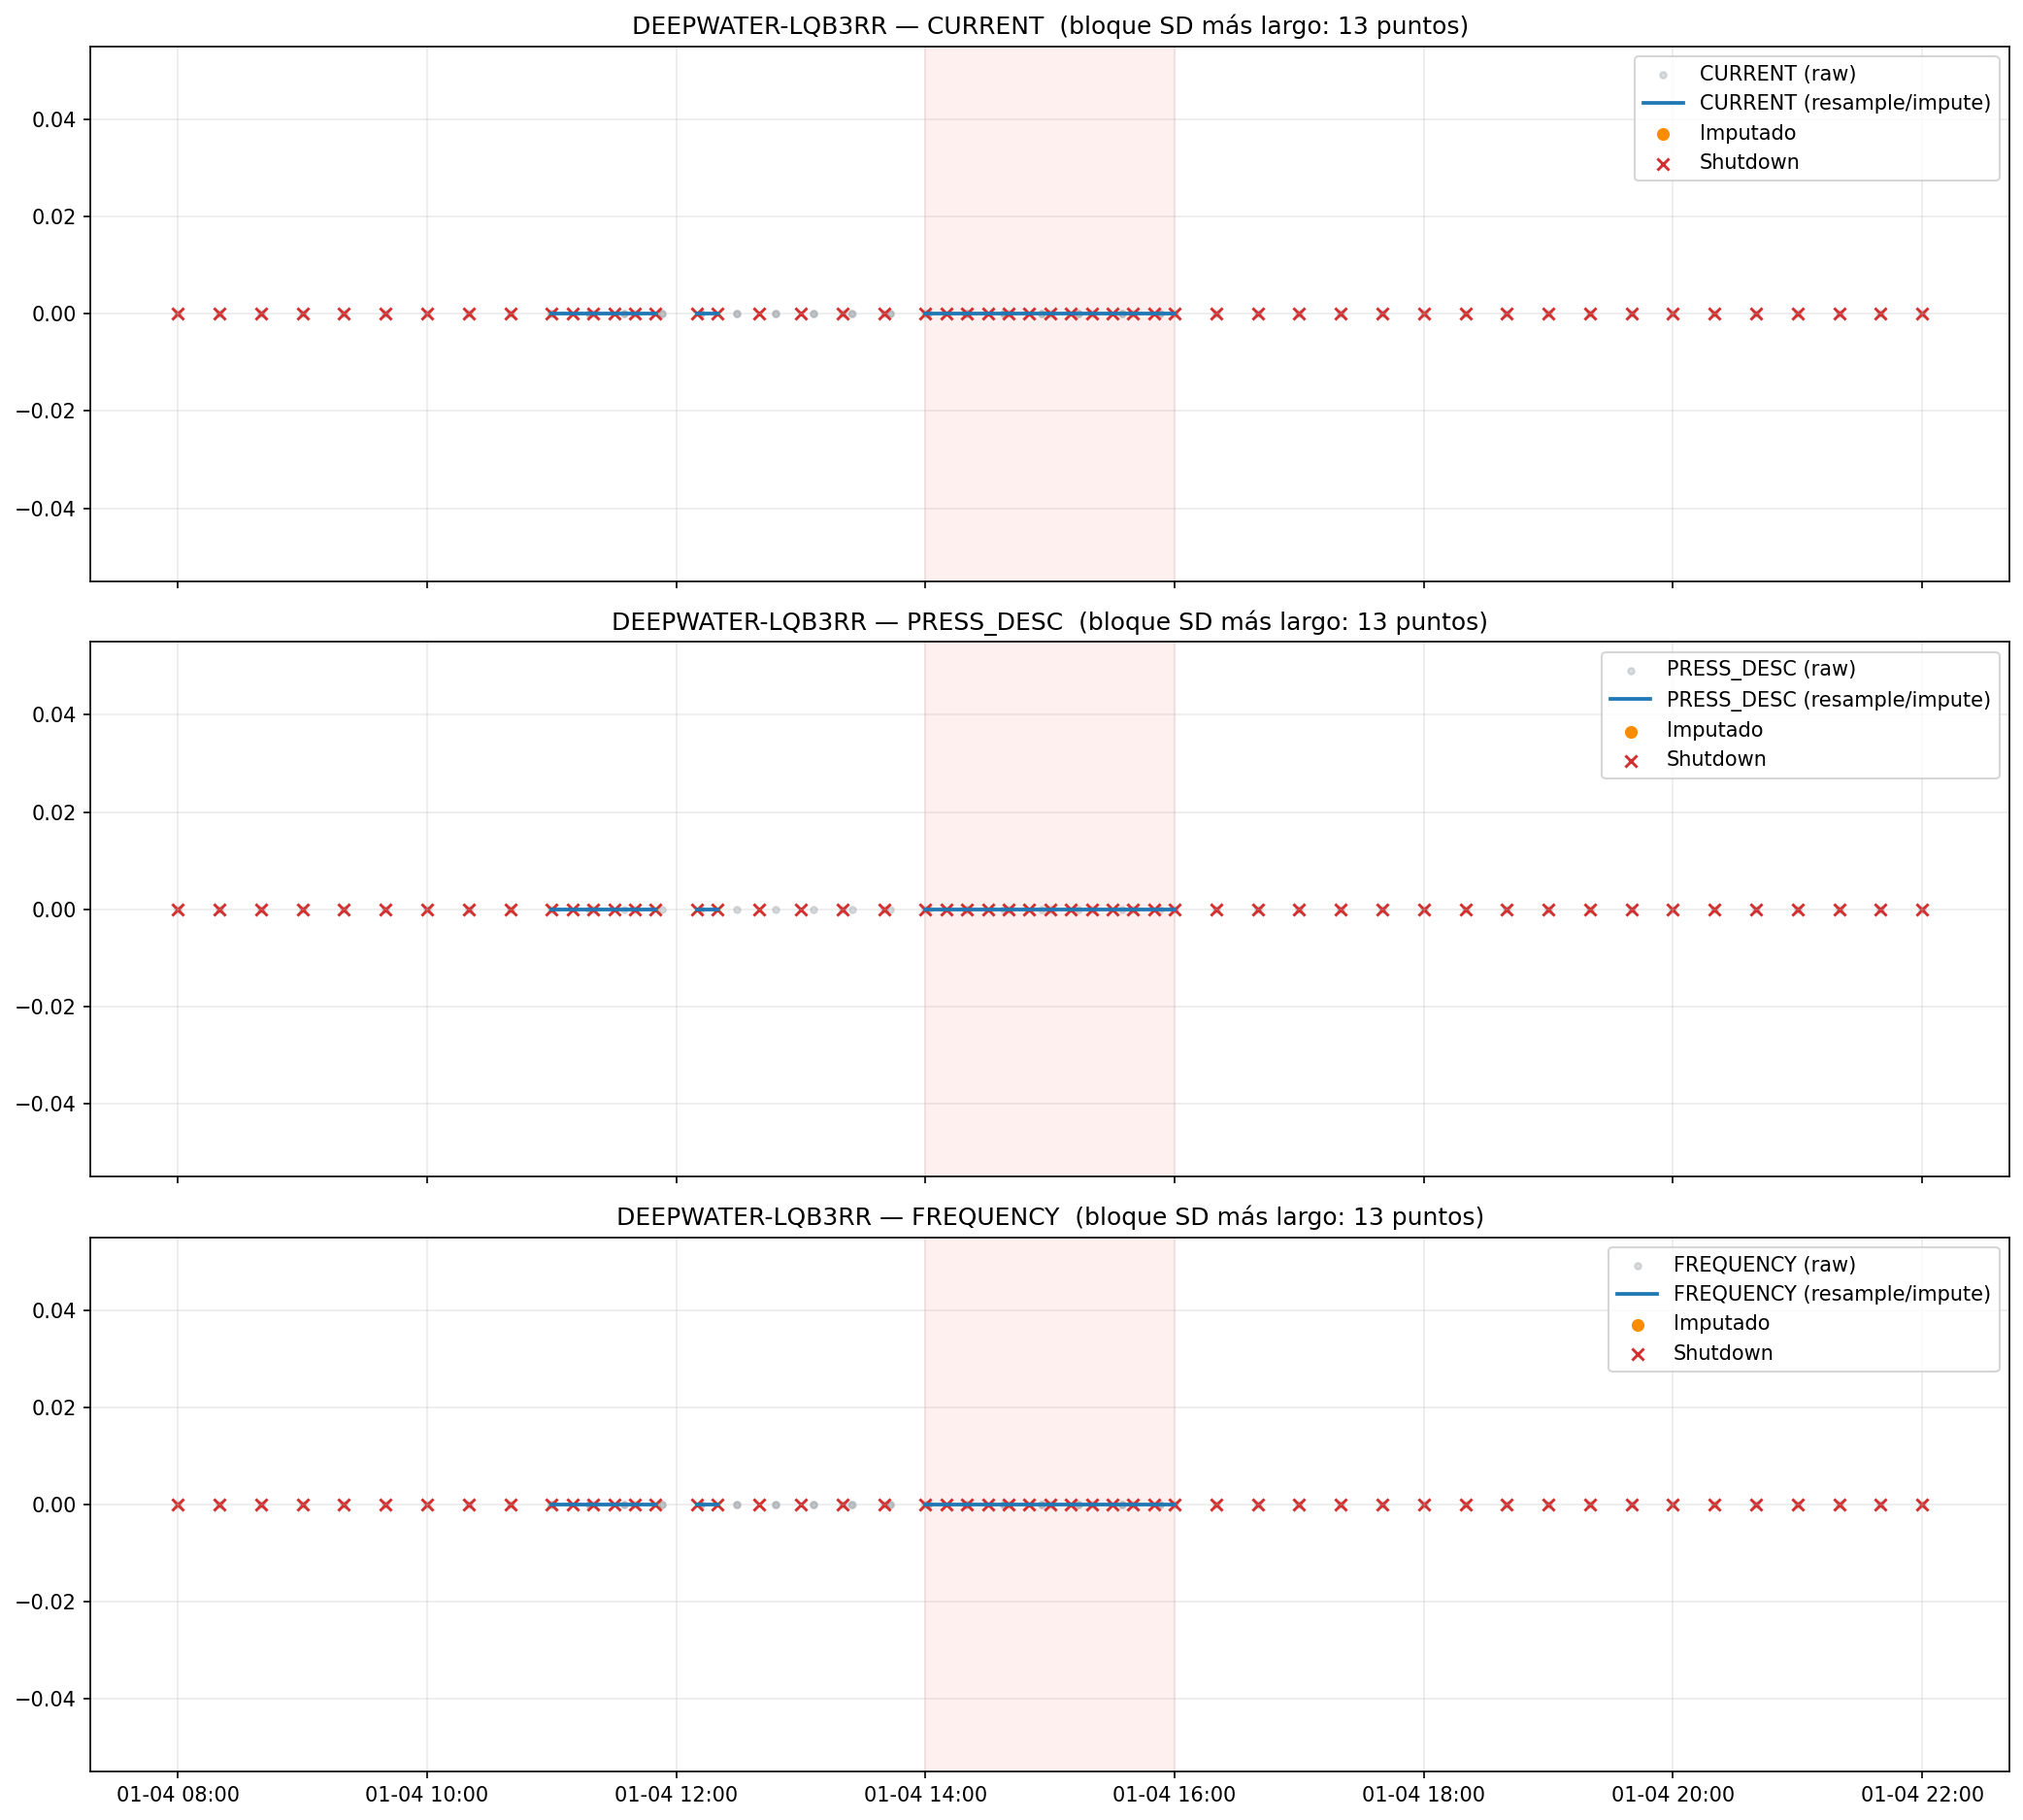

Guardado: DEEPWATER-LQB3RR_SDlong_20200104_1400-20200104_1600_20250919_161802.png | DEEPWATER-LQB3RR_SDlong_20200104_1400-20200104_1600_20250919_161802.svg


In [38]:
# === Graficar el shutdown más largo con contexto y guardar con timestamp ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

def plot_shutdown_block_timestamp(df_raw, df_proc, well_id, pad_h=6,
                                  vars_plot=("CURRENT","PRESS_DESC","FREQUENCY"),
                                  fig_dir=FIG_DIR, dpi=300):
    # Datos del pozo
    b = df_proc[df_proc["WELL_ID"]==well_id].sort_values("DATE").copy()
    a = df_raw[df_raw["WELL_ID"]==well_id].copy()
    if b.empty:
        print(f"[{well_id}] sin datos."); return

    # Serie booleana de shutdown
    sd = b["shutdown_flag"].astype(bool)
    if not sd.any():
        print(f"[{well_id}] no tiene shutdowns."); return

    # Run-length encoding para encontrar bloques de shutdown
    grp = (sd != sd.shift(fill_value=False)).cumsum()
    blocks = (b.assign(_grp=grp)
                .groupby(["_grp","shutdown_flag"])
                .agg(t0=("DATE","min"), t1=("DATE","max"), n=("DATE","size"))
                .reset_index())

    # Tomar el bloque de shutdown más largo
    blk_sd = blocks[blocks["shutdown_flag"]==True].sort_values("n", ascending=False)
    t0, t1, n = blk_sd.iloc[0][["t0","t1","n"]]

    # Ventana con contexto
    start = t0 - pd.Timedelta(hours=pad_h)
    end   = t1 + pd.Timedelta(hours=pad_h)

    a = a[(a["DATE"]>=start) & (a["DATE"]<=end)]
    b = b[(b["DATE"]>=start) & (b["DATE"]<=end)]
    sd = b["shutdown_flag"].astype(bool)
    imp = b["interp_flag_core"].astype(bool)

    # Plot (mismo look & feel)
    nrows = len(vars_plot)
    fig, axes = plt.subplots(nrows, 1, figsize=(14, 4.2*nrows), sharex=True)
    if nrows == 1: axes = [axes]

    for ax, col in zip(axes, vars_plot):
        if col not in b.columns: ax.set_visible(False); continue
        t, y = b["DATE"], b[col]

        # Raw (gris)
        if col in a.columns:
            ax.scatter(a["DATE"], a[col], s=10, alpha=0.35, color="#9AA0A6", label=f"{col} (raw)")

        # Línea procesada (azul)
        ax.plot(t, y, linewidth=1.8, label=f"{col} (resample/impute)")

        # Imputado (naranja)
        m_imp_col = imp & y.notna()
        ax.scatter(t[m_imp_col], y[m_imp_col], s=28, color="#FB8C00", label="Imputado")

        # Shutdown (✖ rojo)
        m_sd_col = sd & y.notna()
        ax.scatter(t[m_sd_col], y[m_sd_col], s=34, marker="x", color="#D32F2F", linewidths=1.4, label="Shutdown")

        # Sombrear el intervalo de shutdown más largo
        ax.axvspan(t0, t1, color="#FDECEA", alpha=0.75, zorder=0)

        ax.set_title(f"{well_id} — {col}  (bloque SD más largo: {n} puntos)")
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))

        # Leyenda sin duplicados
        h, l = ax.get_legend_handles_labels()
        seen, H, L = set(), [], []
        for hh, ll in zip(h, l):
            if ll not in seen: H.append(hh); L.append(ll); seen.add(ll)
        ax.legend(H, L, loc="best", frameon=True)

    fig.tight_layout()

    # Guardar con timestamp + intervalo del shutdown
    ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    safe_well = str(well_id).replace("/", "-").replace("\\", "-").replace(" ", "_")
    span = f"{t0.strftime('%Y%m%d_%H%M')}-{t1.strftime('%Y%m%d_%H%M')}"
    fig_dir = Path(fig_dir); fig_dir.mkdir(parents=True, exist_ok=True)
    out_png = fig_dir / f"{safe_well}_SDlong_{span}_{ts}.png"
    out_svg = fig_dir / f"{safe_well}_SDlong_{span}_{ts}.svg"
    plt.savefig(out_png, dpi=dpi); plt.savefig(out_svg)
    plt.show()
    print(f"Guardado: {out_png.name} | {out_svg.name}")

# --- Selección automática: pozo con más shutdowns que además tenga operación (>0) ---
agg = df_rs.groupby("WELL_ID")["shutdown_flag"].agg(n_sd="sum", n_all="size")
agg["n_op"] = agg["n_all"] - agg["n_sd"]
cand = agg[agg["n_sd"]>0 & (agg["n_op"]>0)].sort_values("n_sd", ascending=False)
well = cand.index[0] if not cand.empty else df_rs["WELL_ID"].iloc[0]

print("Pozo elegido para vista centrada en shutdown:", well)
plot_shutdown_block_timestamp(df_raw=df, df_proc=df_rs, well_id=well, pad_h=6,
                              vars_plot=("CURRENT","PRESS_DESC","FREQUENCY"), dpi=300)
